# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from script_baseline.Baseline_MG import Get_Baseline_MG_feat_pack
from script_baseline.MIGNN import MIGNN2,Graph_DataLoader
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

Using backend: pytorch
[12:00:51] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory


# Load Data

In [2]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'
tmp_df = pd.read_csv(data_file)
cat_smiles = tmp_df['Catalyst'].to_list()
imine_smiles = tmp_df['Imine'].to_list()
thiol_smiles = tmp_df['Thiol'].to_list()
labels = tmp_df['Output'].to_list()
label_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

In [3]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob(mol_dir+'cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob(mol_dir+'imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob(mol_dir+'thiol_*.sdf'),key=sort_func)

sdf_file=cat_files+imine_files+thiol_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [4]:
imine_feat,imine_feat_name_dict=Get_Baseline_MG_feat_pack(imine_files)

../data2/data2_sdf_files/imine_0.sdf
../data2/data2_sdf_files/imine_1.sdf
../data2/data2_sdf_files/imine_2.sdf
../data2/data2_sdf_files/imine_3.sdf
../data2/data2_sdf_files/imine_4.sdf


/PyScripts/PyTorch.dir/LSW/SEMG_MIGNN/SEMG_MIGNN1/baseline/script_baseline/Baseline_MG.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_atom_feats=np.array(all_atom_feats)


In [5]:
cat_feat,cat_feat_name_dict=Get_Baseline_MG_feat_pack(cat_files)

../data2/data2_sdf_files/cat_0.sdf
../data2/data2_sdf_files/cat_1.sdf
../data2/data2_sdf_files/cat_2.sdf
../data2/data2_sdf_files/cat_3.sdf
../data2/data2_sdf_files/cat_4.sdf
../data2/data2_sdf_files/cat_5.sdf
../data2/data2_sdf_files/cat_6.sdf
../data2/data2_sdf_files/cat_7.sdf
../data2/data2_sdf_files/cat_8.sdf
../data2/data2_sdf_files/cat_9.sdf
../data2/data2_sdf_files/cat_10.sdf
../data2/data2_sdf_files/cat_11.sdf
../data2/data2_sdf_files/cat_12.sdf
../data2/data2_sdf_files/cat_13.sdf
../data2/data2_sdf_files/cat_14.sdf
../data2/data2_sdf_files/cat_15.sdf
../data2/data2_sdf_files/cat_16.sdf
../data2/data2_sdf_files/cat_17.sdf
../data2/data2_sdf_files/cat_18.sdf
../data2/data2_sdf_files/cat_19.sdf
../data2/data2_sdf_files/cat_20.sdf
../data2/data2_sdf_files/cat_21.sdf
../data2/data2_sdf_files/cat_22.sdf
../data2/data2_sdf_files/cat_23.sdf
../data2/data2_sdf_files/cat_24.sdf
../data2/data2_sdf_files/cat_25.sdf
../data2/data2_sdf_files/cat_26.sdf
../data2/data2_sdf_files/cat_27.sdf
..

/PyScripts/PyTorch.dir/LSW/SEMG_MIGNN/SEMG_MIGNN1/baseline/script_baseline/Baseline_MG.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_atom_feats=np.array(all_atom_feats)


In [6]:
thiol_feat,thiol_feat_name_dict=Get_Baseline_MG_feat_pack(thiol_files)

../data2/data2_sdf_files/thiol_0.sdf
../data2/data2_sdf_files/thiol_1.sdf
../data2/data2_sdf_files/thiol_2.sdf
../data2/data2_sdf_files/thiol_3.sdf
../data2/data2_sdf_files/thiol_4.sdf


/PyScripts/PyTorch.dir/LSW/SEMG_MIGNN/SEMG_MIGNN1/baseline/script_baseline/Baseline_MG.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_atom_feats=np.array(all_atom_feats)


In [7]:
total_cat_feat = np.array([cat_feat[cat_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in cat_smiles])
total_imine_feat = np.array([imine_feat[imine_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in imine_smiles])
total_thiol_feat = np.array([thiol_feat[thiol_feat_name_dict[smiles_name_dict[tmp_smi]]] for tmp_smi in thiol_smiles])
react_feat = np.concatenate([total_cat_feat,total_imine_feat,total_thiol_feat],axis=1)
labels_std = (np.array(labels)-np.min(labels))/(np.max(labels)-np.min(labels))

# Train Model

In [8]:
batch_size = 32
shuffle = np.array(list(range(len(react_feat))))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
feat_train,y_train = react_feat[train_index],label_std[train_index]
feat_val,y_val = react_feat[val_index],label_std[val_index]

train_gen = Graph_DataLoader(feat_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(feat_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(feat_val,y_val,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()

In [9]:
model = MIGNN2()

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 50
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt')
    print("model saved to %s" % path)  

2022-09-13 12:08:19.664882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 12:08:19.665276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 12:08:19.666323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-13 12:08:19.666348: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

19/19 [==============================] - 9s 173ms/step - loss: 0.0418 - val_loss: 0.0394
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-1
19/19 [==============================] - 2s 88ms/step - loss: 0.0330 - val_loss: 0.0366
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-2
19/19 [==============================] - 2s 88ms/step - loss: 0.0133 - val_loss: 0.0264
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-3
19/19 [==============================] - 1s 62ms/step - loss: 0.0069 - val_loss: 0.0256
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-4
19/19 [==============================] - 2s 91ms/step - loss: 0.0051 - val_loss: 0.0224
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-5
19/19 [==============================] - 2s 84ms/step - loss: 0.0051 - val_loss: 0.0160
model saved to ./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-6
19/19 [==============================] - 2s 83ms/step - loss: 0.0044 - val_loss: 

In [10]:
opt = tf.keras.optimizers.Adam()
new_model =MIGNN2()
new_model.compile(optimizer=opt,loss='mse')
_ = new_model.fit(valid_gen,epochs=1)
checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./dataset/run_data/data2_Baseline_MG_MIGNN.ckpt-50')

y_test_pre=new_model.predict(valid_gen_predict)
y_val=label_std[val_index]
y_val = y_val*(np.max(labels)-np.min(labels))+np.min(labels)
y_pred = y_test_pre*(np.max(labels)-np.min(labels))+np.min(labels)

15/15 [==============================] - 7s 62ms/step - loss: 0.0420


# Results

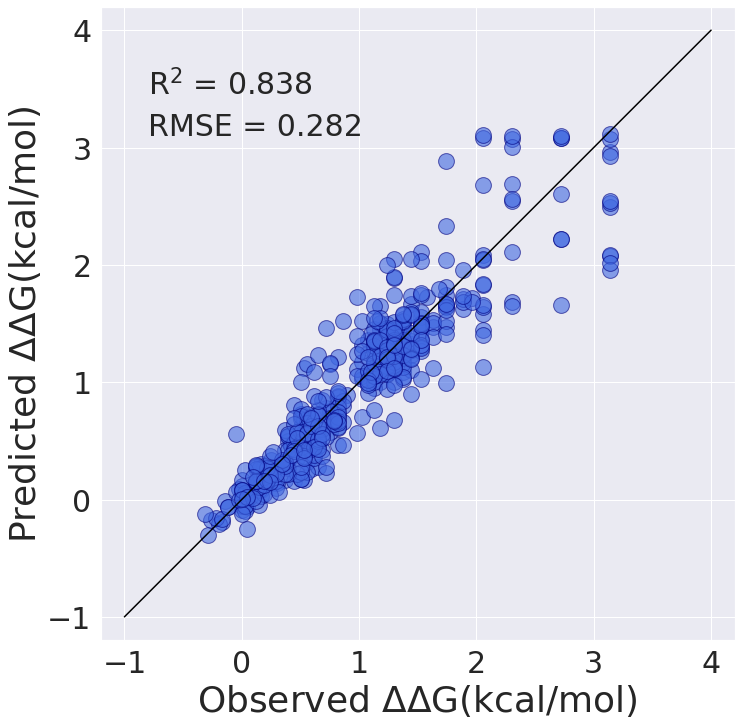

In [11]:
y_val=np.load('../result/data2_Baseline_MG_MIGNN_y_val.npy')
y_pred=np.load('../result/data2_Baseline_MG_MIGNN_y_pred.npy')

sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')

plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()

ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)

plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [12]:
np.save('../result/data2_Baseline_MG_MIGNN_y_val.npy',y_val)
np.save('../result/data2_Baseline_MG_MIGNN_y_pred.npy',y_pred)